In [1]:
import numpy as np
import pandas as pd
import os

In [11]:
import time

In [12]:
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.expand_frame_repr', True) 

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import random
import datetime
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Imports for better visualization
from matplotlib import rcParams
#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 4)
rcParams['figure.dpi'] = 150
#rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 8
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'

In [7]:
train = pd.read_csv('./data/train_foreclosure.csv')
test = pd.read_csv('./data/test_foreclosure.csv')
customers = pd.read_excel('./data/Customers_31JAN2019.xlsx')
query = pd.read_excel('./data/RF_Final_Data.xlsx')

In [8]:
agreements = pd.read_excel('./data/LMS_31JAN2019.xlsx')

In [13]:
train_data = train.merge(agreements,on = 'AGREEMENTID',how= 'left').drop_duplicates()
test_data = test.merge(agreements,on = 'AGREEMENTID',how= 'left').drop_duplicates()

In [14]:
categorical = train_data.select_dtypes(include=[np.object])
categorical = categorical.columns
numeric = train_data.select_dtypes(include=[np.int,np.float])
numeric = numeric.columns
datetime = train_data.select_dtypes(include=[np.datetime64])
datetime = datetime.columns

In [15]:
categorical, numeric, datetime

(Index(['CITY', 'PRODUCT', 'NPA_IN_LAST_MONTH', 'NPA_IN_CURRENT_MONTH'], dtype='object'),
 Index(['AGREEMENTID', 'FORECLOSURE', 'CUSTOMERID', 'LOAN_AMT',
        'NET_DISBURSED_AMT', 'CURRENT_ROI', 'ORIGNAL_ROI', 'CURRENT_TENOR',
        'ORIGNAL_TENOR', 'DUEDAY', 'PRE_EMI_DUEAMT', 'PRE_EMI_RECEIVED_AMT',
        'PRE_EMI_OS_AMOUNT', 'EMI_DUEAMT', 'EMI_RECEIVED_AMT', 'EMI_OS_AMOUNT',
        'EXCESS_AVAILABLE', 'EXCESS_ADJUSTED_AMT', 'BALANCE_EXCESS',
        'NET_RECEIVABLE', 'OUTSTANDING_PRINCIPAL', 'PAID_PRINCIPAL',
        'PAID_INTEREST', 'MONTHOPENING', 'LAST_RECEIPT_AMOUNT', 'NET_LTV',
        'COMPLETED_TENURE', 'BALANCE_TENURE', 'DPD', 'FOIR', 'SCHEMEID', 'MOB'],
       dtype='object'),
 Index(['INTEREST_START_DATE', 'AUTHORIZATIONDATE', 'LAST_RECEIPT_DATE'], dtype='object'))

#### basic cleaning only


1. include this small dummy categories into its parent categories
1. normalize skewed numeric variables,(EDA distributions)
1. Datetime variables to be dropped

In [16]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

In [17]:
# Normalization
def norm(data):
    #### variables for minmax
    skewed = ['LOAN_AMT','NET_DISBURSED_AMT','PRE_EMI_DUEAMT', 'PRE_EMI_RECEIVED_AMT',
        'PRE_EMI_OS_AMOUNT','EMI_DUEAMT', 'EMI_RECEIVED_AMT', 'EMI_OS_AMOUNT',
        'EXCESS_AVAILABLE', 'EXCESS_ADJUSTED_AMT', 'BALANCE_EXCESS',
        'NET_RECEIVABLE', 'OUTSTANDING_PRINCIPAL', 'PAID_PRINCIPAL',
        'PAID_INTEREST', 'MONTHOPENING', 'LAST_RECEIPT_AMOUNT']
    data[skewed] = minmax.fit_transform(data[skewed])


In [18]:
norm(train_data)

In [19]:
norm(test_data)

In [14]:
## adding dummy categories to parent categories

In [15]:
# npa_last_month and npa_current_month

In [20]:
train_data['NPA_IN_LAST_MONTH'].value_counts()

0      7308
#N/     508
Yes     214
NPA       3
yes       1
Name: NPA_IN_LAST_MONTH, dtype: int64

In [21]:
train_data['NPA_IN_CURRENT_MONTH'].value_counts()

0      7814
Yes     265
yes       1
Name: NPA_IN_CURRENT_MONTH, dtype: int64

In [22]:
train_data['NPA_IN_LAST_MONTH'].replace(['yes','Yes'],['YES','YES'],inplace = True)
train_data['NPA_IN_CURRENT_MONTH'].replace(['yes','Yes'],['YES','YES'],inplace = True)
test_data['NPA_IN_LAST_MONTH'].replace(['yes','Yes'],['YES','YES'],inplace = True)
test_data['NPA_IN_CURRENT_MONTH'].replace(['yes','Yes'],['YES','YES'],inplace = True)

In [23]:
corr = train_data.corr()
corr['FORECLOSURE']

AGREEMENTID             -0.276735
FORECLOSURE              1.000000
CUSTOMERID              -0.276817
LOAN_AMT                -0.004955
NET_DISBURSED_AMT       -0.004698
CURRENT_ROI             -0.006418
ORIGNAL_ROI             -0.010118
CURRENT_TENOR            0.104760
ORIGNAL_TENOR            0.139815
DUEDAY                   0.158156
PRE_EMI_DUEAMT          -0.005782
PRE_EMI_RECEIVED_AMT    -0.005667
PRE_EMI_OS_AMOUNT       -0.004267
EMI_DUEAMT               0.004030
EMI_RECEIVED_AMT         0.005082
EMI_OS_AMOUNT           -0.010219
EXCESS_AVAILABLE         0.004263
EXCESS_ADJUSTED_AMT      0.004619
BALANCE_EXCESS          -0.001191
NET_RECEIVABLE          -0.007843
OUTSTANDING_PRINCIPAL   -0.005219
PAID_PRINCIPAL          -0.001777
PAID_INTEREST            0.012129
MONTHOPENING            -0.003318
LAST_RECEIPT_AMOUNT     -0.005080
NET_LTV                  0.032306
COMPLETED_TENURE         0.070595
BALANCE_TENURE           0.077161
DPD                     -0.000477
FOIR          

### Feature Engineering

In [21]:
train_data.columns

Index(['AGREEMENTID', 'FORECLOSURE', 'CUSTOMERID', 'LOAN_AMT',
       'NET_DISBURSED_AMT', 'INTEREST_START_DATE', 'CURRENT_ROI',
       'ORIGNAL_ROI', 'CURRENT_TENOR', 'ORIGNAL_TENOR', 'DUEDAY',
       'AUTHORIZATIONDATE', 'CITY', 'PRE_EMI_DUEAMT', 'PRE_EMI_RECEIVED_AMT',
       'PRE_EMI_OS_AMOUNT', 'EMI_DUEAMT', 'EMI_RECEIVED_AMT', 'EMI_OS_AMOUNT',
       'EXCESS_AVAILABLE', 'EXCESS_ADJUSTED_AMT', 'BALANCE_EXCESS',
       'NET_RECEIVABLE', 'OUTSTANDING_PRINCIPAL', 'PAID_PRINCIPAL',
       'PAID_INTEREST', 'MONTHOPENING', 'LAST_RECEIPT_DATE',
       'LAST_RECEIPT_AMOUNT', 'NET_LTV', 'COMPLETED_TENURE', 'BALANCE_TENURE',
       'DPD', 'FOIR', 'PRODUCT', 'SCHEMEID', 'NPA_IN_LAST_MONTH',
       'NPA_IN_CURRENT_MONTH', 'MOB'],
      dtype='object')

In [22]:
train_data['CURRENT_TENOR'].fillna(train_new['ORIGNAL_TENOR'],inplace = True)
train_data['LAST_RECEIPT_AMOUNT'].fillna(0,inplace = True)# as its not paid on that date
train_data['DPD'].fillna(0,inplace = True)# as the tenure hasn't even started for the NaN cases
train_data['BALANCE_TENURE'].fillna(train_new['ORIGNAL_TENOR'],inplace = True)

test_data['CURRENT_TENOR'].fillna(test_new['ORIGNAL_TENOR'],inplace = True)
test_data['LAST_RECEIPT_AMOUNT'].fillna(0,inplace = True)# as its not paid on that date
test_data['DPD'].fillna(0,inplace = True)# as the tenure hasn't even started for the NaN cases
test_data['BALANCE_TENURE'].fillna(test_new['ORIGNAL_TENOR'],inplace = True)



In [23]:
test_data[test_data['MOB'].isin(train_data['MOB'].unique())]['MOB'].nunique()
## so all the MOB codes are the same in train and test
# lets check if a MOB code signifies only one label

97

In [24]:
train_data[train_data['MOB']==39].FORECLOSURE.value_counts()

0    2134
1     374
Name: FORECLOSURE, dtype: int64

In [25]:
train_data[train_data['MOB']==40].FORECLOSURE.value_counts()

0    2006
1     358
Name: FORECLOSURE, dtype: int64

In [26]:
## almost all the codes have same distribution of labels, lets try including the label into features,
## if doesnt turn out good then will remove, rn we will use mean encoding, try label encoding as well

In [27]:
### dropping a few features, keeping PRODUCT, NPA_IN_LAST_MONTH
drop = ['CUSTOMERID','INTEREST_START_DATE','AUTHORIZATIONDATE','CITY','NPA_IN_LAST_MONTH','NPA_IN_CURRENT_MONTH','LAST_RECEIPT_DATE', 'SCHEMEID']
train_new = train_data.drop(drop,axis = 1)
test_new = test_data.drop(drop,axis = 1)

In [28]:
### mean encoding

In [29]:
global means, means1#, means2

In [30]:
means = train_new.groupby(['PRODUCT']).FORECLOSURE.mean()
# means1 =  train_new.groupby(['MOB']).FORECLOSURE.mean()
# means2 =   train_new.groupby(['NPA_IN_CURRENT_MONTH']).FORECLOSURE.mean()

In [31]:
def map(data):
    data['PRODUCT'] = data['PRODUCT'].map(means)
#     data['MOB'] = data['MOB'].map(means1)
#     data['NPA_IN_CURRENT_MONTH'] = data['NPA_IN_CURRENT_MONTH'].map(means2)

In [32]:
map(train_new)

In [33]:
map(test_new)

### Model

In [35]:
from sklearn.model_selection import train_test_split

In [59]:
X_train,X_val,y_train,y_val = train_test_split(train_new.drop(['FORECLOSURE'],axis = 1),train_new['FORECLOSURE'],test_size = 0.2,random_state = 42)

In [60]:
                                     
x_t = X_train.drop(['AGREEMENTID'],axis = 1)
# x_t = x_t.values
# y_train = y_train.values
# y_train = y_train[:,0]
print('x_t', x_t)
print('y_train', y_train)


x_v = X_val.drop(['AGREEMENTID'],axis = 1)
# x_v = x_v.values
# y_val = y_val.values
# y_valid = y_valid[:,0]
print('x_v',x_v)
print('y_valid', y_val)


x_t [[7.33798957e-03 7.33798957e-03 1.62311760e+01 ... 4.90000000e-01
  1.51046771e-01 5.30000000e+01]
 [1.58783485e-02 1.58783485e-02 1.06126920e+01 ... 5.40000000e-01
  3.42102941e-01 4.00000000e+00]
 [2.63659093e-03 2.63659093e-03 1.59190380e+01 ... 4.40000000e-01
  2.38073737e-04 1.60000000e+01]
 ...
 [3.53284413e-03 3.53284413e-03 1.74797280e+01 ... 3.70000000e-01
  1.51046771e-01 1.80000000e+01]
 [4.15524710e-03 4.15524710e-03 1.74797280e+01 ... 3.00000000e-01
  1.51046771e-01 4.20000000e+01]
 [7.16962840e-03 7.16117054e-03 1.74797280e+01 ... 3.90000000e-01
  1.51046771e-01 2.00000000e+00]]
y_train [0 0 0 ... 0 0 0]
x_v [[3.56290337e-02 3.56290337e-02 1.37340720e+01 ... 5.00000000e-02
  2.38073737e-04 2.00000000e+00]
 [4.29554947e-03 4.29554947e-03 1.43583480e+01 ... 4.70000000e-01
  1.51046771e-01 6.00000000e+00]
 [2.14324463e-02 2.14324463e-02 1.49826240e+01 ... 1.33000000e+00
  2.38073737e-04 4.00000000e+00]
 ...
 [3.44797100e-03 3.44797100e-03 1.52947620e+01 ... 4.80000000e-0

In [55]:
import xgboost 
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=10,min_child_weight=5)
model.fit(x_t,y_train)
model.score(x_t,y_train)
# 0.9791502596206468

0.9791502596206468

In [61]:
model.score(x_v,y_val)
# 0.9754127901544376

0.9763738537314628

In [62]:
1- np.mean(y_val)

0.8857535672811244

In [63]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, classification_report
probab = model.predict_proba(x_v)
probab = probab[:,1]
roc_auc_score(y_val,probab)
# 0.9942758878268141

0.9943588772201765

In [65]:
print('AUC Score is {}'.format(roc_auc_score(y_val,probab)))

AUC Score is 0.9943588772201765


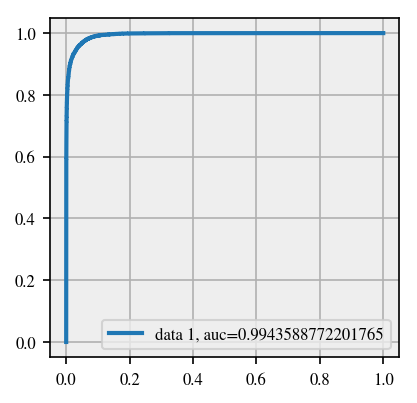

In [71]:
plt.figure(figsize=(3,3))
y_pred_proba = model.predict_proba(x_v)[::,1]
fpr, tpr, _ = roc_curve(y_val,  y_pred_proba)
auc = roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [73]:
confusion_matrix(y_val,model.predict(x_v))

array([[66090,   268],
       [ 1502,  7057]])

In [74]:
print(classification_report(y_val,model.predict(x_v)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     66358
           1       0.96      0.82      0.89      8559

   micro avg       0.98      0.98      0.98     74917
   macro avg       0.97      0.91      0.94     74917
weighted avg       0.98      0.98      0.98     74917



### But these results are basically raw ones with one agreement having more than one datapoint so lets take mode of the labels for an agreement as a final prediction and for probabilities take mean of all probabilities of an agreement 

In [75]:
check_x = x_v.set_index(X_val['AGREEMENTID'])

In [76]:
check_x.set_index(X_val['AGREEMENTID'],inplace = True)

In [77]:
check_y = pd.DataFrame(y_val).set_index(X_val['AGREEMENTID'])

In [78]:
check_pred = pd.DataFrame(model.predict(x_v)).set_index(X_val['AGREEMENTID'])

In [79]:
check_probab = pd.DataFrame(model.predict_proba(x_v)).set_index(X_val['AGREEMENTID'])

In [80]:
import scipy.stats as stats
# new_y = check_y.reset_index().groupby(['AGREEMENTID'])['FORECLOSURE'].agg({'y':np.mean})
new_y = check_y.reset_index().groupby(['AGREEMENTID'])['FORECLOSURE'].agg(lambda x: stats.mode(x)[0][0])

In [81]:
# new_pred = check_pred.reset_index().groupby(['AGREEMENTID'])[0].agg({'y':stats.mode(axis = None)})
new_pred = check_pred.reset_index().groupby(['AGREEMENTID'])[0].agg(lambda x: stats.mode(x)[0][0])

In [82]:
new_probab = check_probab.reset_index().groupby(['AGREEMENTID'])[1].agg({'probab':np.mean})

In [83]:
np.mean(new_pred==new_y)

0.9784098105820715

In [84]:
new_y.value_counts()

0    15688
1     1681
Name: FORECLOSURE, dtype: int64

In [85]:
roc_auc_score(new_y,new_probab)

0.993846469571274

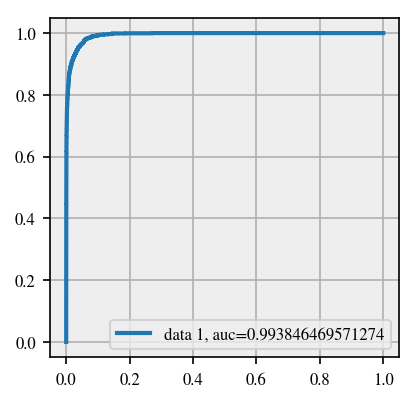

In [86]:
plt.figure(figsize=(3,3))
y_pred_proba_new = new_probab
fpr, tpr, _ = roc_curve(new_y,  y_pred_proba_new)
auc = roc_auc_score(new_y, y_pred_proba_new)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [87]:
confusion_matrix(new_y,new_pred)

array([[15668,    20],
       [  355,  1326]])

In [88]:
print(classification_report(new_y,new_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15688
           1       0.99      0.79      0.88      1681

   micro avg       0.98      0.98      0.98     17369
   macro avg       0.98      0.89      0.93     17369
weighted avg       0.98      0.98      0.98     17369



### 1st Submission

In [89]:
X = train_new.drop(['FORECLOSURE','AGREEMENTID'],axis = 1)
y = train_new['FORECLOSURE']

In [90]:
model_sub =  XGBClassifier(max_depth=10,min_child_weight=5)
model_sub.fit(X,y)
model_sub.score(X,y)

0.980768049975306

In [91]:
x_t = test_new.drop(['AGREEMENTID','FORECLOSURE'],axis = 1)

In [92]:
check_pred_test = pd.DataFrame(model_sub.predict(x_t)).set_index(test_new['AGREEMENTID'])

In [93]:
check_probab_test = pd.DataFrame(model_sub.predict_proba(x_t)).set_index(test_new['AGREEMENTID'])

In [94]:
new_pred_test = check_pred_test.reset_index().groupby(['AGREEMENTID'])[0].agg(lambda x: stats.mode(x)[0][0])

In [95]:
new_probab_test = check_probab_test.reset_index().groupby(['AGREEMENTID'])[1].agg({'probab':np.mean})

In [96]:
new_probab_test.shape

(13342, 1)

In [97]:
np.mean(test['AGREEMENTID']==new_probab_test.index)

1.0

In [98]:
new_probab_test.reset_index(inplace = True)

In [99]:
new_probab_test.rename(columns={'probab':'FORECLOSURE'},inplace = True)

In [100]:
new_probab_test.to_csv('5th_submission.csv',index = False,header=True)

In [1]:
### increased the leaderboard score by 5th submission